<a href="https://colab.research.google.com/github/apschlissel/w266-final-project/blob/main/BERT_reddit_%2B_NB%2C_n_%3D_500_(Kevin).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation and Setup

In [1]:
!pip install -q transformers

     |████████████████████████████████| 3.8 MB 3.2 MB/s 
     |████████████████████████████████| 895 kB 4.3 MB/s 
     |████████████████████████████████| 596 kB 31.9 MB/s 
     |████████████████████████████████| 6.5 MB 34.8 MB/s 
     |████████████████████████████████| 67 kB 2.4 MB/s 


In [2]:
!pip install simpletransformers

     |████████████████████████████████| 249 kB 5.4 MB/s 
     |████████████████████████████████| 1.2 MB 45.4 MB/s 
     |████████████████████████████████| 10.1 MB 33.7 MB/s 
     |████████████████████████████████| 1.7 MB 38.5 MB/s 
     |████████████████████████████████| 325 kB 31.0 MB/s 
     |████████████████████████████████| 43 kB 1.2 MB/s 
     |████████████████████████████████| 144 kB 42.7 MB/s 
     |████████████████████████████████| 181 kB 33.3 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 136 kB 38.2 MB/s 
     |████████████████████████████████| 212 kB 37.9 MB/s 
     |████████████████████████████████| 1.1 MB 33.5 MB/s 
     |████████████████████████████████| 127 kB 15.4 MB/s 
     |████████████████████████████████| 94 kB 2.5 MB/s 
     |████████████████████████████████| 144 kB 36.4 MB/s 
     |████████████████████████████████| 271 kB 39.5 MB/s 
     |████████████████████████████████| 111 kB 35.1 MB/s 
     |██████████████

In [3]:
!pip install setuptools==59.5.0

     |████████████████████████████████| 952 kB 5.5 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 61.3.0
    Uninstalling setuptools-61.3.0:
      Successfully uninstalled setuptools-61.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
ipykernel 6.11.0 requires setuptools>=60, but you have setuptools 59.5.0 which is incompatible.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.11.0 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.32.0 which is incompatible.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
# Useful Links / Source Code
# Source: https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
# Source: https://github.com/susanli2016/NLP-with-Python/blob/master/Text_Classification_With_BERT.ipynb
# Source: https://towardsdatascience.com/how-to-use-the-reddit-api-in-python-5e05ddfd1e5c
# Source: https://medium.com/@senthilnathangautham/colab-gcp-compute-how-to-link-them-together-98747e8d940e
# Source: https://stackoverflow.com/questions/49031798/when-i-use-google-colaboratory-how-to-save-image-weights-in-my-google-drive

In [5]:
from __future__ import print_function
import ipywidgets as widgets
from transformers import pipeline
from simpletransformers.t5 import T5Model, T5Args
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging
import numpy as np
import torch
from tqdm.notebook import tqdm
from transformers import BertModel, BertConfig
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
import json
import random
import math
import requests
from bs4 import BeautifulSoup

# Pull data from reddit by scraping from webpage (HTML) and using Reddit API

- Select 5 slang-heavy "subreddits" (subcategories of forums within Reddit.com) by hand
- Select 5 random subreddits


In [6]:
# note that CLIENT_ID refers to 'personal use script' and SECRET_TOKEN to 'token'
auth = requests.auth.HTTPBasicAuth('pigKA_TKnDkXcatEGcbo8g', 'nawGKK2MfPtC6vKz8TjaNEnmYfAggA')

# here we pass our login method (password), username, and password
data = {'grant_type': 'password',
        'username': 'Katsuuu100',
        'password': 'Testing159753'}

# setup our header info, which gives reddit a brief description of our app
headers = {'User-Agent': 'MyBot/0.0.1'}

# send our request for an OAuth token
res = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth, data=data, headers=headers)

# convert response to JSON and pull access_token value
TOKEN = res.json()['access_token']

# add authorization to our headers dictionary
headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}

# while the token is valid (~2 hours) we just add headers=headers to our requests
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)

<Response [200]>

In [7]:
# HTML web scraper, scrape top subreddits, SFW only.
# 
# Source: https://realpython.com/beautiful-soup-web-scraper-python/
# Source: https://stackoverflow.com/questions/40210093/how-do-i-scrape-only-div-class-quotetext-from-a-website-using-python


URL = "http://redditlist.com/sfw/"
page = requests.get(URL)

soup = BeautifulSoup(page.content, "html.parser")
# print(soup.prettify())
job_elements = soup.find_all("div", class_="listing-item")

# print(job_elements[0])

# Filter to only the Top 125 Most subscribed subreddits
job_elements = job_elements[125:250]

master_subreddit_list = []
# Find subreddit names
for job_element in job_elements:
  links = job_element.find_all("a")
  for link in links:
    print(link.text.strip())
    master_subreddit_list.append(link.text.strip())

announcements
funny
AskReddit
gaming
aww
Music
pics
worldnews
movies
science
todayilearned
videos
news
Showerthoughts
Jokes
food
askscience
IAmA
EarthPorn
gifs
nottheonion
books
DIY
explainlikeimfive
Art
LifeProTips
space
sports
mildlyinteresting
Documentaries
gadgets
memes
tifu
photoshopbattles
UpliftingNews
GetMotivated
dataisbeautiful
listentothis
history
philosophy
television
InternetIsBeautiful
Futurology
WritingPrompts
OldSchoolCool
personalfinance
nosleep
creepy
TwoXChromosomes
wallstreetbets
technology
wholesomememes
AdviceAnimals
interestingasfuck
Fitness
politics
lifehacks
WTF
oddlysatisfying
relationship_advice
NatureIsFuckingLit
Minecraft
travel
facepalm
Whatcouldgowrong
nextfuckinglevel
pcmasterrace
leagueoflegends
BlackPeopleTwitter
me_irl
Unexpected
dankmemes
bestof
dadjokes
buildapc
Tinder
PS4
MadeMeSmile
AnimalsBeingBros
Damnthatsinteresting
tattoos
CryptoCurrency
AnimalsBeingJerks
photography
nba
AnimalsBeingDerps
gardening
BikiniBottomTwitter
trippinthroughtime
Watch

In [8]:
# Pick 5 random subreddits
five_random_subreddits = random.choices(master_subreddit_list, k=5)
print(five_random_subreddits)

['Showerthoughts', 'stocks', 'AnimalsBeingBros', 'explainlikeimfive', 'WritingPrompts']


In [9]:
# Source: https://towardsdatascience.com/how-to-use-the-reddit-api-in-python-5e05ddfd1e5c
# Source: https://pynative.com/python-random-choice/
# Pull from 5 classes. 5 classes = 5 subreddits.

my_list_of_dictionaries = []
total = 0
# Target Count for test set = 100.
n = int(math.ceil(20/0.20/25))

# url_list_check = [f"https://oauth.reddit.com/r/{five_random_subreddits[0]}/new/",
#           f"https://oauth.reddit.com/r/{five_random_subreddits[1]}/new/",
#           f"https://oauth.reddit.com/r/{five_random_subreddits[2]}/new/",
#           f"https://oauth.reddit.com/r/{five_random_subreddits[3]}/new/",
#           f"https://oauth.reddit.com/r/{five_random_subreddits[4]}/new/"
#           ]

url_list_check = [f"https://oauth.reddit.com/r/wallstreetbets/new/",
          f"https://oauth.reddit.com/r/teenagers/new/",
          f"https://oauth.reddit.com/r/copypasta/new/",
          f"https://oauth.reddit.com/r/genz/new/",
          f"https://oauth.reddit.com/r/unpopularopinion/new/",
          # f"https://oauth.reddit.com/r/frat/new/"
          ]

for i in range(len(url_list_check)):
    
  # print(url_list_check[i])
  res_check = requests.get(url_list_check[i],
                    headers=headers,
                    params={"limit": "1"})
  
  # print(res_check)
  # print(json.dumps(res_check.json()["data"]["children"][0]["data"]["name"], indent=4))
  name = res_check.json()["data"]["children"][0]["data"]["name"]
  page_count = 25
  
  for j in range(n):

    # url_list = [f"https://oauth.reddit.com/r/{five_random_subreddits[0]}/new/?count={page_count}&after={name}",
    #         f"https://oauth.reddit.com/r/{five_random_subreddits[1]}/new/?count={page_count}&after={name}",
    #         f"https://oauth.reddit.com/r/{five_random_subreddits[2]}/new/?count={page_count}&after={name}",
    #         f"https://oauth.reddit.com/r/{five_random_subreddits[3]}/new/?count={page_count}&after={name}",
    #         f"https://oauth.reddit.com/r/{five_random_subreddits[4]}/new/?count={page_count}&after={name}"
    #         ]

    url_list = [f"https://oauth.reddit.com/r/wallstreetbets/new/?count={page_count}&after={name}",
            f"https://oauth.reddit.com/r/teenagers/new/?count={page_count}&after={name}",
            f"https://oauth.reddit.com/r/copypasta/new/?count={page_count}&after={name}",
            f"https://oauth.reddit.com/r/genz/new/?count={page_count}&after={name}",
            f"https://oauth.reddit.com/r/unpopularopinion/new/?count={page_count}&after={name}",
            # f"https://oauth.reddit.com/r/frat/new/?count={page_count}&after={name}"
            ]
    
    print("Page Count:", page_count)
    print("Name:", name)
    print("Url:", url_list[i])
    
    res = requests.get(url_list[i],
                    headers=headers)
                    # params={"limit": "100"})

    reddit_dictionary = res.json()

    for k in range(len(reddit_dictionary["data"]["children"])):
      my_dictionary = {}
      my_dictionary["subreddit"] = reddit_dictionary["data"]["children"][k]["data"]["subreddit"]
      my_dictionary["text"] = reddit_dictionary["data"]["children"][k]["data"]["selftext"]
      # If a reddit post is has no body text:
      if my_dictionary["text"] == "":
        # Replace with title of reddit post.
        my_dictionary["text"] = reddit_dictionary["data"]["children"][k]["data"]["title"]
      
      print(my_dictionary["text"])
      # my_dictionary["title"] = reddit_dictionary["data"]["children"][k]["data"]["title"]
      # my_dictionary["url"] = reddit_dictionary["data"]["children"][k]["data"]["url"]
      # print(reddit_dictionary["data"]["children"][k]["data"]["subreddit"])
      # print(reddit_dictionary["data"]["children"][k]["data"]["selftext"])
      # print(reddit_dictionary["data"]["children"][k]["data"]["url"])
      my_list_of_dictionaries.append(my_dictionary)
      total += 1
      name = reddit_dictionary["data"]["children"][k]["data"]["name"]
    # print(json.dumps(my_list_of_dictionaries, indent=4, sort_keys=False))
    
    page_count += 25

print("Total gathered:", total)

Streaming output truncated to the last 5000 lines.
*doom - total doom
*spazz - dwarf jester rising, sweatin’ to the oldies, crush kill destroy
*rudimentary peni - death church
*extreme noise terror - damage 381, in it for life
*terrorizer - world downfall
*insult - i wanna be a burn victim
*disrupt - unrest
*dying fetus - reign supreme 
*skinless - progression towards evil, foreshadowing our demise
*man is the bastard - sum of the men “the brutality continues…”, thoughtless
*noothgrush - live for nothing
*discharge - hear nothing say nothing 
*zyanose - druge and slave
*devourment - molesting the decapitated
*leftover crack - rock the 40 oz. reloaded, 
*phobia - lifeless god
*capitalist casualties - disassembly line
*amebix - arise
*sordo - sordo/chulo split 
*nausea - extinction, smash racism 
*bathory - under the sign of the black mark, requiem
*gorgoroth - quantos possunt ad satanita trahunt
*venom - black metal
I am bored and I would like some people to talk to, just want to be pro

# Create Pandas Dataframe from Extracted Reddit Posts Above

In [10]:
# Source: https://github.com/susanli2016/NLP-with-Python/blob/master/Text_Classification_With_BERT.ipynb
# Convert list of dictionaries into pandas df
df = pd.DataFrame(my_list_of_dictionaries)
df.head()

,subreddit,text
0,wallstreetbets,Power to the Ape 🦍 🦧
1,wallstreetbets,"Since u/skedditgetit asked for it so nicely, h..."
2,wallstreetbets,polish ape thats buying buying a house next mo...
3,wallstreetbets,tick. tick. tick. tick.
4,wallstreetbets,Should I Have Sold These Before Close???


In [11]:
# Check if there is body text in reddit post
print(df['text'][0])

Power to the Ape 🦍 🦧


In [12]:
# Check if total is correct per subreddit
df['subreddit'].value_counts()

wallstreetbets      100
teenagers           100
copypasta           100
GenZ                100
unpopularopinion    100
Name: subreddit, dtype: int64

In [13]:
print(pd.unique(df['subreddit'].values))

['wallstreetbets' 'teenagers' 'copypasta' 'GenZ' 'unpopularopinion']


In [14]:
possible_labels = df.subreddit.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'GenZ': 3,
 'copypasta': 2,
 'teenagers': 1,
 'unpopularopinion': 4,
 'wallstreetbets': 0}

In [15]:
df['label'] = df.subreddit.replace(label_dict)

In [16]:
df.head()

,subreddit,text,label
0,wallstreetbets,Power to the Ape 🦍 🦧,0
1,wallstreetbets,"Since u/skedditgetit asked for it so nicely, h...",0
2,wallstreetbets,polish ape thats buying buying a house next mo...,0
3,wallstreetbets,tick. tick. tick. tick.,0
4,wallstreetbets,Should I Have Sold These Before Close???,0


# NLTK Preprocessing of the Reddit Post Column

In [17]:
# Source: https://skimai.com/fine-tuning-bert-for-sentiment-analysis/
import nltk
import re
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    # s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Remove r/name
    s = re.sub(r'(r/.*?)[\s]', ' ', s)
    # Remove "amp"
    s = re.sub(r'(amp)', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    # s = " ".join([word for word in s.split()
    #               if word not in stopwords.words('english')
    #               or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
# Source: https://stackoverflow.com/questions/34962104/how-can-i-use-the-apply-function-for-a-single-column
df['text'] = df['text'].apply(text_preprocessing)


In [19]:
pd.set_option('display.max_colwidth', None)
df.head()

,subreddit,text,label
0,wallstreetbets,power to the ape,0
1,wallstreetbets,since u skedditgetit asked for it so nicely here s some soft core gme loss porn,0
2,wallstreetbets,polish ape thats buying buying a house next month going full retard with my mandatory mortgage deductible help,0
3,wallstreetbets,tick tick tick tick,0
4,wallstreetbets,should i have sold these before close ? ? ?,0


## Load Slangit Data

Slangit is a direct translation of slang data

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
slang = pd.read_csv('/content/gdrive/MyDrive/W266/final_project/slangit_group_edit.csv')
slang.head(20)

,Slang Term,Meaning
0,143,i love you
1,404,page not found
2,411,information
3,420,marijuana
4,1337,leet speak
5,@@-o,tattletale
6,@teotd,at the end of the day
7,^5,high five
8,0773h,hello
9,10m,10 minutes


In [22]:
slangit_dict = slang.set_index('Slang Term').to_dict()
slangit_dict = slangit_dict['Meaning']

In [23]:
keys_values = slangit_dict.items()
slangit_dict = {str(key): str(value) for key, value in keys_values}
# slangit_dict =  {k.lower(): v for k, v in slangit_dict.items()}

In [24]:
# SOURCE: https://skimai.com/fine-tuning-bert-for-sentiment-analysis/
# Source: https://stackoverflow.com/questions/52976850/case-insensitive-regex-returning-original-pattern
# Source: https://stackoverflow.com/questions/554013/regular-expression-to-split-on-spaces-unless-in-quotes
def slang_lookup(text, dictionary):
    
    # print(dictionary)
    pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in slangit_dict.keys()) + r')(?!\w)')
    # pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in slangit_dict.keys()) + r')(?!\w)', re.IGNORECASE)
    # Source: https://regex101.com/r/Rx6FHX/1
    # Source: https://stackoverflow.com/questions/69932098/python-regex-match-space-separated-words-that-contain-two-or-fewer-o-characters
    # pattern = re.compile(r'(?<!\S)(' + '|'.join(re.escape(key) for key in slangit_dict.keys()) + r')(?:[^\s])[^\s]*(?!\S)')
    # Source: https://stackoverflow.com/questions/1751301/regex-match-entire-words-only
    # pattern = re.compile(r'(\w+)' + '|'.join(re.escape(dictionary)))
    # print(pattern)
    result = pattern.sub(lambda m: dictionary.get(m.group()), text)
    # result= pattern.sub(lambda x: dictionary[x.group()], text)

    return result

In [25]:
my_text = "i want to awesome you up sooo bad how i'm feeling nipples hard not financial advice its a a piece of media that spreads via the internet"

print(slang_lookup(my_text, slangit_dict))

i want to awesome you up sooo bad how i am feeling nipples hard not financial advice its a a piece onlyfans media that spreads via the internet


## Apply Slangit regex replace to reddit data (KEVIN EDIT for BERT)

In [26]:
# Merge Train and Validation Sets for BERT purposes only.
# pd.concat([data1, data2], axis=0)
# df_train = pd.concat([df[df.index.isin(X_train)], df[df.index.isin(X_val)]], axis=0)
df_train = df
len(df_train)

500

In [27]:
df_train['text_deslanged'] = df_train['text'].apply(lambda x: slang_lookup(x, slangit_dict))

In [28]:
df_train['text_deslanged'].head()

0                                                                                                  power to the ape
1                  since you skedditgetit asked for it significant other nicely here s some weak core gme loss porn
2    polish ape thats buying buying a house next month going full retard with my mandatory mortgage deductible help
3                                                                                               tick tick tick tick
4                                                                       should i have sold these before close ? ? ?
Name: text_deslanged, dtype: object

In [29]:
# False = There was slang, text was changed.
# True = No slang, text was not changed.
#df_train['same'] = df_train['title_and_text'].equals(df_train['title_and_text_deslanged'])
df_train['same'] = np.where(df_train['text'] == df_train['text_deslanged'] , True, False)
df_train['same'].head()

0     True
1    False
2     True
3     True
4     True
Name: same, dtype: bool

In [30]:
df_train['same'].value_counts()

False    434
True      66
Name: same, dtype: int64

## Check regex deslang, correct examples where it is deslanged incorrectly

In [31]:
df_train.head()

,subreddit,text,label,text_deslanged,same
0,wallstreetbets,power to the ape,0,power to the ape,True
1,wallstreetbets,since u skedditgetit asked for it so nicely here s some soft core gme loss porn,0,since you skedditgetit asked for it significant other nicely here s some weak core gme loss porn,False
2,wallstreetbets,polish ape thats buying buying a house next month going full retard with my mandatory mortgage deductible help,0,polish ape thats buying buying a house next month going full retard with my mandatory mortgage deductible help,True
3,wallstreetbets,tick tick tick tick,0,tick tick tick tick,True
4,wallstreetbets,should i have sold these before close ? ? ?,0,should i have sold these before close ? ? ?,True


In [32]:
deslanged_for_bert = df_train[['text_deslanged', 'label']]

In [33]:
print(label_dict)

{'wallstreetbets': 0, 'teenagers': 1, 'copypasta': 2, 'GenZ': 3, 'unpopularopinion': 4}


In [34]:
swapped_dict = {}
swapped_dict = dict([(value, key) for key, value in label_dict.items()])
print(swapped_dict)

{0: 'wallstreetbets', 1: 'teenagers', 2: 'copypasta', 3: 'GenZ', 4: 'unpopularopinion'}


In [35]:
deslanged_for_bert['subreddit'] = df_train['label'].map(swapped_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
deslanged_for_bert = deslanged_for_bert[['subreddit', 'text_deslanged', 'label']]
deslanged_for_bert = deslanged_for_bert.rename(columns={"text_deslanged": "text"})
deslanged_for_bert.head()

,subreddit,text,label
0,wallstreetbets,power to the ape,0
1,wallstreetbets,since you skedditgetit asked for it significant other nicely here s some weak core gme loss porn,0
2,wallstreetbets,polish ape thats buying buying a house next month going full retard with my mandatory mortgage deductible help,0
3,wallstreetbets,tick tick tick tick,0
4,wallstreetbets,should i have sold these before close ? ? ?,0


In [37]:
deslanged_for_bert.groupby(['subreddit', 'label']).count()

,,text
subreddit,label,
GenZ,3,100
copypasta,2,100
teenagers,1,100
unpopularopinion,4,100
wallstreetbets,0,100


In [38]:
# path = '/content/gdrive/MyDrive/W266/final_project/input_for_bert.csv'

# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   deslanged_for_bert.to_csv(f)

# Load Translated CSV

In [39]:
# # Load Translated CSV
# from google.colab import drive
# drive.mount('/content/gdrive')
# path = '/content/gdrive/MyDrive/W266/final_project/input_for_bert.csv'

# df = pd.read_csv(path)
# df.head()

In [40]:
df = deslanged_for_bert

# [Run from here after loading Translated Dataframe from CSV] Define X_train, X_val variables

- Split all data into train and test sets.
- Check to see if there is the same amount of train and test data.


---



In [41]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [42]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [43]:
df.groupby(['subreddit', 'label', 'data_type']).count()

text
subreddit        label data_type      
GenZ             3     train        80
                       val          20
copypasta        2     train        80
                       val          20
teenagers        1     train        80
                       val          20
unpopularopinion 4     train        80
                       val          20
wallstreetbets   0     train        80
                       val          20

In [44]:
df.head()

,subreddit,text,label,data_type
0,wallstreetbets,power to the ape,0,train
1,wallstreetbets,since you skedditgetit asked for it significant other nicely here s some weak core gme loss porn,0,val
2,wallstreetbets,polish ape thats buying buying a house next month going full retard with my mandatory mortgage deductible help,0,val
3,wallstreetbets,tick tick tick tick,0,train
4,wallstreetbets,should i have sold these before close ? ? ?,0,train


# Run BERT Model

In [67]:
# Bert model begins
# Source: https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [84]:
# Source: https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
# Source: https://stackoverflow.com/questions/64680863/bert-tokenizing-error-valueerror-input-nan-is-not-valid-should-be-a-string-a
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [85]:
print(type(df[df.data_type=='train'].text.values))
print(len(df[df.data_type=='train'].text.values))

<class 'numpy.ndarray'>
400


In [86]:
print(len(encoded_data_train))
print(len(encoded_data_val))

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

print(len(input_ids_train))
print(len(attention_masks_train))
print(len(labels_train))

print(len(input_ids_val))
print(len(attention_masks_val))
print(len(labels_val))

3
3
400
400
400
100
100
100


In [87]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [88]:
len(dataset_train), len(dataset_val)

(400, 100)

In [89]:
possible_labels = df.subreddit.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'GenZ': 3,
 'copypasta': 2,
 'teenagers': 1,
 'unpopularopinion': 4,
 'wallstreetbets': 0}

In [90]:
# Source: https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [91]:
# Source: https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [92]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [93]:
# Mark says to just run 3 epochs max.
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [94]:
# Source: https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [95]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [97]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [98]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Source: https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
f1_list = []
train_loss_list = []
val_loss_list = []

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
        #print(model(**inputs))
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/W266/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    train_loss_list.append(loss_train_avg)
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    val_loss_list.append(val_loss)
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    f1_list.append(val_f1)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/134 [00:00<?, ?it/s]

In [ ]:
# Plot F1 and losses over epochs
acc = f1_list
#val_acc = model.history['val_accuracy']

loss = train_loss_list
val_loss = val_loss_list

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='F1 Score')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('F1 Score')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/W266/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
accuracy_per_class(predictions, true_vals)

In [ ]:
# from sklearn.metrics import confusion_matrix,accuracy_score
# cm_bert = confusion_matrix(true_vals, predictions)
# ac_bert = accuracy_score(true_vals, predictions)

# Naive Bayes Model

In [ ]:
# # Naive Bayes Model
# # Source: https://www.analyticsvidhya.com/blog/2021/01/a-guide-to-the-naive-bayes-algorithm/
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# # X_train, X_val, y_train, y_val
# print(X_train.shape)
# print(X_val.shape)
# # Reshape makes it (2400, 1) instead of (2400, )
# # Source: https://stackoverflow.com/questions/58498187/sklearn-transform-error-expected-2d-array-got-1d-array-instead
# X_train2 = sc.fit_transform(X_train.reshape(-1,1))
# X_test2 = sc.transform(X_val.reshape(-1,1))

In [ ]:
# Source: https://www.analyticsvidhya.com/blog/2021/01/a-guide-to-the-naive-bayes-algorithm/
# Feature analysis to see if any words are sticking out
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train.reshape(-1,1), y_train)

In [ ]:
y_pred = classifier.predict(X_val.reshape(-1,1))

0.2


[Text(0, 0.5, 'photography'),
 Text(0, 1.5, 'PS4'),
 Text(0, 2.5, 'IdiotsInCars'),
 Text(0, 3.5, 'HighQualityGifs'),
 Text(0, 4.5, 'leagueoflegends')]

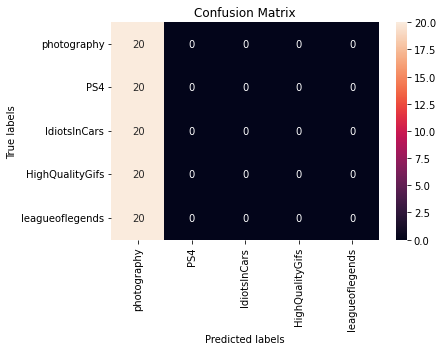

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm_nb = confusion_matrix(y_val, y_pred)
ac_nb = accuracy_score(y_val, y_pred)
print(ac_nb)

# Source: https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
ax= plt.subplot()
sns.heatmap(cm_nb, annot=True, fmt='g', ax=ax) #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
# Source: https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.xaxis.set_ticklabels(pd.unique(df['subreddit'].values))
ax.yaxis.set_ticklabels(pd.unique(df['subreddit'].values))